In [ ]:
!pip install mlflow dagshub optuna lightgbm imbalanced-learn kaleido gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.2/263.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB

In [ ]:
import dagshub
dagshub.init(repo_owner='Ritk-Raikwar', repo_name='reddit-comment-sentiment-analysis', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=628d30ed-4f64-42c0-b904-9f7b15fc5c22&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=e8f2502b20b25856d7ec68a789248215786e1cee8e1877c9bcb4f85fc0efb03a




Output()

🚀 Tuning Stacking Ensemble (Word2Vec + LGBM + LogReg + KNN)...
   (Word2Vec is smaller (100 dims), so ADASYN should run faster!)

✅ Tuning Complete. Training Best Model...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Final Word2Vec Ensemble Report:
              precision    recall  f1-score   support

          -1       0.46      0.32      0.38      1650
           0       0.66      0.75      0.70      2529
           1       0.65      0.68      0.66      3154

    accuracy                           0.62      7333
   macro avg       0.59      0.58      0.58      7333
weighted avg       0.61      0.62      0.61      7333



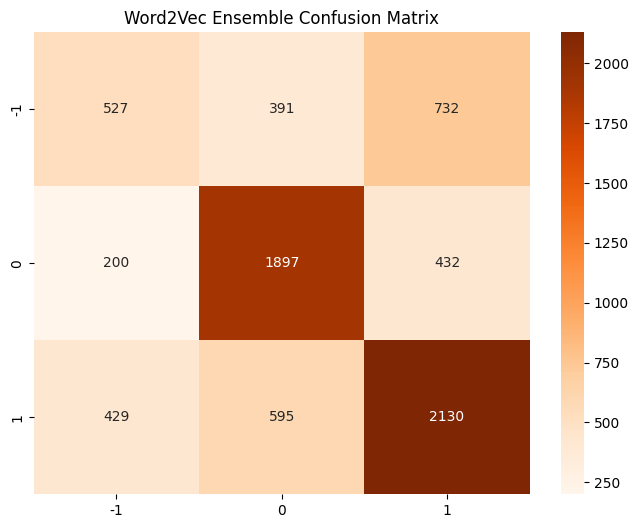

🏃 View run Stacking_Word2Vec_Ensemble at: https://dagshub.com/Ritk-Raikwar/reddit-comment-sentiment-analysis.mlflow/#/experiments/9/runs/1df96a5aa12f4ba2802694823abf53f1
🧪 View experiment at: https://dagshub.com/Ritk-Raikwar/reddit-comment-sentiment-analysis.mlflow/#/experiments/9


In [ ]:
import pandas as pd
import numpy as np
import mlflow
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# --- 1. Load & Process Data ---
try:
    df = pd.read_csv('reddit_preprocessed.csv')
    df = df.drop('Unnamed: 0', axis=1, errors='ignore')
    df = df.dropna(subset=['clean_comment', 'category'])
    df['clean_comment'] = df['clean_comment'].astype(str)
except FileNotFoundError:
    print("❌ Error: 'reddit_preprocessed.csv' not found.")
    raise

# Encode Labels
le = LabelEncoder()
y = le.fit_transform(df['category'])
class_names = [str(cls) for cls in le.classes_]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_comment'], y, test_size=0.2, random_state=42, stratify=y
)

X_train_df = pd.DataFrame(X_train, columns=['clean_comment'])
X_test_df = pd.DataFrame(X_test, columns=['clean_comment'])

# --- 2. Custom Transformers ---

class CleanTextMetadataExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            text_data = X.iloc[:, 0]
        else:
            text_data = pd.Series(X)

        features = pd.DataFrame(index=text_data.index)
        word_lists = text_data.str.split()

        features['word_count'] = word_lists.str.len()
        features['unique_ratio'] = word_lists.apply(
            lambda x: len(set(x)) / len(x) if isinstance(x, list) and len(x) > 0 else 0
        )
        stop_words = set(ENGLISH_STOP_WORDS)
        features['stopword_ratio'] = word_lists.apply(
            lambda x: sum(1 for w in x if w in stop_words) / len(x) if isinstance(x, list) and len(x) > 0 else 0
        )
        return features.fillna(0)

# ✅ NEW: Word2Vec Transformer
class MeanWord2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=2):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        # 1. Prepare sentences (tokenized)
        if isinstance(X, pd.DataFrame):
            sentences = [text.split() for text in X.iloc[:, 0]]
        else:
            sentences = [text.split() for text in X]

        # 2. Train Word2Vec on YOUR data
        self.model = Word2Vec(sentences, vector_size=self.vector_size,
                              window=self.window, min_count=self.min_count, workers=1)
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            sentences = [text.split() for text in X.iloc[:, 0]]
        else:
            sentences = [text.split() for text in X]

        # 3. Average the vectors for each sentence
        vectors = []
        for sentence in sentences:
            if not sentence:
                vectors.append(np.zeros(self.vector_size))
                continue

            # Get embedding for each word if it exists in vocabulary
            word_vecs = [self.model.wv[word] for word in sentence if word in self.model.wv]

            if len(word_vecs) == 0:
                vectors.append(np.zeros(self.vector_size))
            else:
                vectors.append(np.mean(word_vecs, axis=0))

        return np.array(vectors)

# --- 3. Define Optuna Objective ---
mlflow.set_experiment("EXP 10 - Tuned Stacking Ensemble")
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # Hyperparameters
    lgbm_n_estimators = trial.suggest_int('lgbm_n_estimators', 50, 200)
    lgbm_learning_rate = trial.suggest_float('lgbm_learning_rate', 0.01, 0.2)
    lgbm_num_leaves = trial.suggest_int('lgbm_num_leaves', 20, 60)
    lr_C = trial.suggest_float('lr_C', 0.1, 10.0, log=True)
    knn_n_neighbors = trial.suggest_int('knn_n_neighbors', 3, 15)

    # ✅ Feature Processing: Word2Vec + Metadata
    preprocessor = ColumnTransformer(
        transformers=[
            ('w2v', MeanWord2VecVectorizer(vector_size=100), 'clean_comment'), # Changed from TF-IDF
            ('meta', SklearnPipeline([
                ('extractor', CleanTextMetadataExtractor()),
                ('scaler', StandardScaler())
            ]), 'clean_comment')
        ],
        remainder='drop'
    )

    # Pipelines
    lgbm_pipeline = SklearnPipeline([
        ('preprocessor', preprocessor),
        ('clf', LGBMClassifier(
            n_estimators=lgbm_n_estimators,
            learning_rate=lgbm_learning_rate,
            num_leaves=lgbm_num_leaves,
            class_weight='balanced',
            objective='multiclass',
            random_state=42,
            verbose=-1,
            n_jobs=1
        ))
    ])

    logreg_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('oversampler', ADASYN(random_state=42, sampling_strategy='minority')),
        ('clf', LogisticRegression(C=lr_C, max_iter=1000, solver='lbfgs'))
    ])

    stacking_clf = StackingClassifier(
        estimators=[
            ('lgbm', lgbm_pipeline),
            ('lr_adasyn', logreg_pipeline)
        ],
        final_estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights='distance'),
        cv=3,
        n_jobs=1
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(stacking_clf, X_train_df, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

    return scores.mean()

print("🚀 Tuning Stacking Ensemble (Word2Vec + LGBM + LogReg + KNN)...")
print("   (Word2Vec is smaller (100 dims), so ADASYN should run faster!)")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=8)

# --- 4. Final Training ---
print("\n✅ Tuning Complete. Training Best Model...")
best_p = study.best_params

preprocessor = ColumnTransformer(
    transformers=[
        ('w2v', MeanWord2VecVectorizer(vector_size=100), 'clean_comment'),
        ('meta', SklearnPipeline([
            ('extractor', CleanTextMetadataExtractor()),
            ('scaler', StandardScaler())
        ]), 'clean_comment')
    ], remainder='drop'
)

final_lgbm = SklearnPipeline([
    ('preprocessor', preprocessor),
    ('clf', LGBMClassifier(
        n_estimators=best_p['lgbm_n_estimators'],
        learning_rate=best_p['lgbm_learning_rate'],
        num_leaves=best_p['lgbm_num_leaves'],
        class_weight='balanced', objective='multiclass', random_state=42, verbose=-1
    ))
])

final_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversampler', ADASYN(random_state=42, sampling_strategy='minority')),
    ('clf', LogisticRegression(C=best_p['lr_C'], max_iter=1000))
])

final_stack = StackingClassifier(
    estimators=[('lgbm', final_lgbm), ('lr_adasyn', final_lr)],
    final_estimator=KNeighborsClassifier(n_neighbors=best_p['knn_n_neighbors'], weights='distance'),
    cv=3, n_jobs=-1
)

final_stack.fit(X_train_df, y_train)
y_pred = final_stack.predict(X_test_df)

# --- 5. Logging ---
# ✅ CHANGED RUN NAME
with mlflow.start_run(run_name="Stacking_Word2Vec_Ensemble"):
    mlflow.log_params(best_p)
    mlflow.log_param("vectorizer", "Word2Vec (100 dims)")

    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    print("\n📊 Final Word2Vec Ensemble Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    mlflow.log_metric("accuracy", report['accuracy'])
    mlflow.log_metric("macro_f1", report['macro avg']['f1-score'])

    for label in class_names:
        if label in report:
            safe_lbl = label.replace("-", "neg")
            mlflow.log_metric(f"{safe_lbl}_recall", report[label]['recall'])
            mlflow.log_metric(f"{safe_lbl}_f1", report[label]['f1-score'])

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
    plt.title("Word2Vec Ensemble Confusion Matrix")
    plt.savefig("w2v_cm.png")
    mlflow.log_artifact("w2v_cm.png")
    plt.show()